<a href="https://colab.research.google.com/github/Mohamed-Diagne/Deep-Learning-Covid19-Spatial-Forcasting/blob/main/Deep_Learning_Covid_Spatial_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid 19 Spatial Forecasting**

### 📚 Context and Contributions

Our work builds on the paper *A Deep Learning Approach to Population Based COVID-19 Case Prediction in the US*, which we adapted to the French context by performing the analysis at the **departmental level**.

However, we identified a key limitation in the original study: while it focuses on time-dependent COVID-19 forecasting, it relies on **static regression models** (Ridge and Lasso), which are not well-suited for capturing temporal dependencies.

To address this issue, we implemented a **Long Short-Term Memory (LSTM)** model, which is more appropriate for sequential data. This choice follows recent advances in the field, notably the work of García‐Cremades et al. (2021), *Improving prediction of COVID‐19 evolution by fusing epidemiological and mobility data* (Nature Portfolio).

Beyond this improvement, our contribution extends the literature in two important ways:
- We introduce **dynamic spatial analysis** through **Moran’s I index** to assess the spatial distribution of prediction errors.
- We incorporate **model interpretability** using **Integrated Gradients**, an aspect often overlooked in previous studies.

Together, these enhancements offer a more comprehensive and interpretable framework for predicting COVID-19 case trajectories in France.

---

### 📖 References

[1] García‐Cremades, S. *et al.* (2021). *Improving prediction of COVID‐19 evolution by fusing epidemiological and mobility data*. Nature Portfolio.

[2] Kuo, C.-P., & Fu, J. S. (2020). *Evaluating the impact of mobility on COVID-19 pandemic with machine learning hybrid predictions*. *Science of the Total Environment*.

[3] Sundrani, S., & Zhang, A. (2021). *A Deep Learning Approach to Population Based COVID-19 Case Prediction in the US*. *CS230 Project Report*, Stanford University.

[4] Schwabe, A., Persson, J., & Feuerriegel, S. (2021). *Predicting COVID-19 Spread from Large-Scale Mobility Data*. *arXiv preprint* arXiv:2103.XXXXX.


&nbsp;

## **📊 Step 1: Dataset Overview and Variable Definitions**

This project aims to predict the short-term evolution of COVID-19 positive cases at the **French department level** by leveraging epidemiological indicators, mobility trends, and socio-economic characteristics.

The dataset has been **pre-cleaned** and is ready for modeling.

---

### 🧩 Variable Definitions

**General Information**
- **date_x**: Date of observation.
- **dep**: Department code (French administrative region).
- **sub_region_1**: Department name.

**Epidemiological Indicators**
- **tx_pos**: COVID-19 test positivity rate (%).
- **r**: Effective reproduction number (average number of people infected by one case).
- **to**: Intensive care unit occupancy rate (%).
- **pos**: Number of positive COVID-19 cases detected (baseline).
- **pos_t_plus_2** to **pos_t_plus_10**: Number of positive cases predicted for T+2 to T+10 days.

**Mobility Trends (percentage change from pre-COVID baseline)**
- **retail_and_recreation_percent_change_from_baseline**: Visits to retail and recreation locations (%).
- **grocery_and_pharmacy_percent_change_from_baseline**: Visits to grocery and pharmacy stores (%).
- **parks_percent_change_from_baseline**: Visits to parks (%).
- **transit_stations_percent_change_from_baseline**: Usage of public transport stations (%).
- **workplaces_percent_change_from_baseline**: Visits to workplaces (%).
- **residential_percent_change_from_baseline**: Time spent at home (%).

**Socio-economic Characteristics**
- **Taux_chomage**: Local unemployment rate (%).
- **Taux_pauvrete**: Local poverty rate (%).
- **Revenu_median**: Median household income (euros).
- **Population_municipale**: Local population size.

---


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/df_covid.csv"
df = pd.read_csv(file_path)

# Show the first few rows
df.head()


,date_x,dep,tx_pos,r,to,pos,pos_t_plus_2,pos_t_plus_3,pos_t_plus_4,pos_t_plus_5,...,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Taux_chomage,Taux_pauvreté,Revenu_median,Population_municipale
0,2020-03-18,Ain,2.65,1.02,0.062612,9.0,9.0,9.0,9.0,9.0,...,-78.0,-44.0,-33.0,-63.0,-62.0,28.0,5.9,10.8,24810.0,671289.0
1,2020-03-19,Ain,2.65,1.02,0.132379,9.0,9.0,9.0,9.0,9.0,...,-77.0,-38.0,-42.0,-69.0,-67.0,33.0,5.9,10.8,24810.0,671289.0
2,2020-03-20,Ain,2.65,1.02,0.155635,9.0,9.0,9.0,9.0,9.0,...,-79.0,-40.0,-44.0,-75.0,-68.0,37.0,5.9,10.8,24810.0,671289.0
3,2020-03-21,Ain,2.65,1.02,0.173524,9.0,9.0,9.0,9.0,9.0,...,-86.0,-59.0,-64.0,-76.0,-56.0,25.0,5.9,10.8,24810.0,671289.0
4,2020-03-22,Ain,2.65,1.02,0.212880,9.0,9.0,9.0,9.0,9.0,...,-81.0,-66.0,-73.0,-82.0,-53.0,18.0,5.9,10.8,24810.0,671289.0


In [ ]:
# Quick missing value check
df.isna().sum()


,0
date_x,0
dep,0
tx_pos,0
r,0
to,0
pos,0
pos_t_plus_2,0
pos_t_plus_3,0
pos_t_plus_4,0
pos_t_plus_5,0


In [ ]:
#  Removing rows for the department "Deux-Sèvres" (too many missing values)

# Check if the problematic value is in the 'sub_region_1' column
df = df[df['sub_region_1'] != 'Deux-SÃ¨vres'].reset_index(drop=True)

#  Rows with "Deux-SÃ¨vres" removed
print(" Removed rows with sub_region_1 == 'Deux-SÃ¨vres'")
print(f"New dataset shape: {df.shape}")


 Removed rows with sub_region_1 == 'Deux-SÃ¨vres'
New dataset shape: (51012, 26)


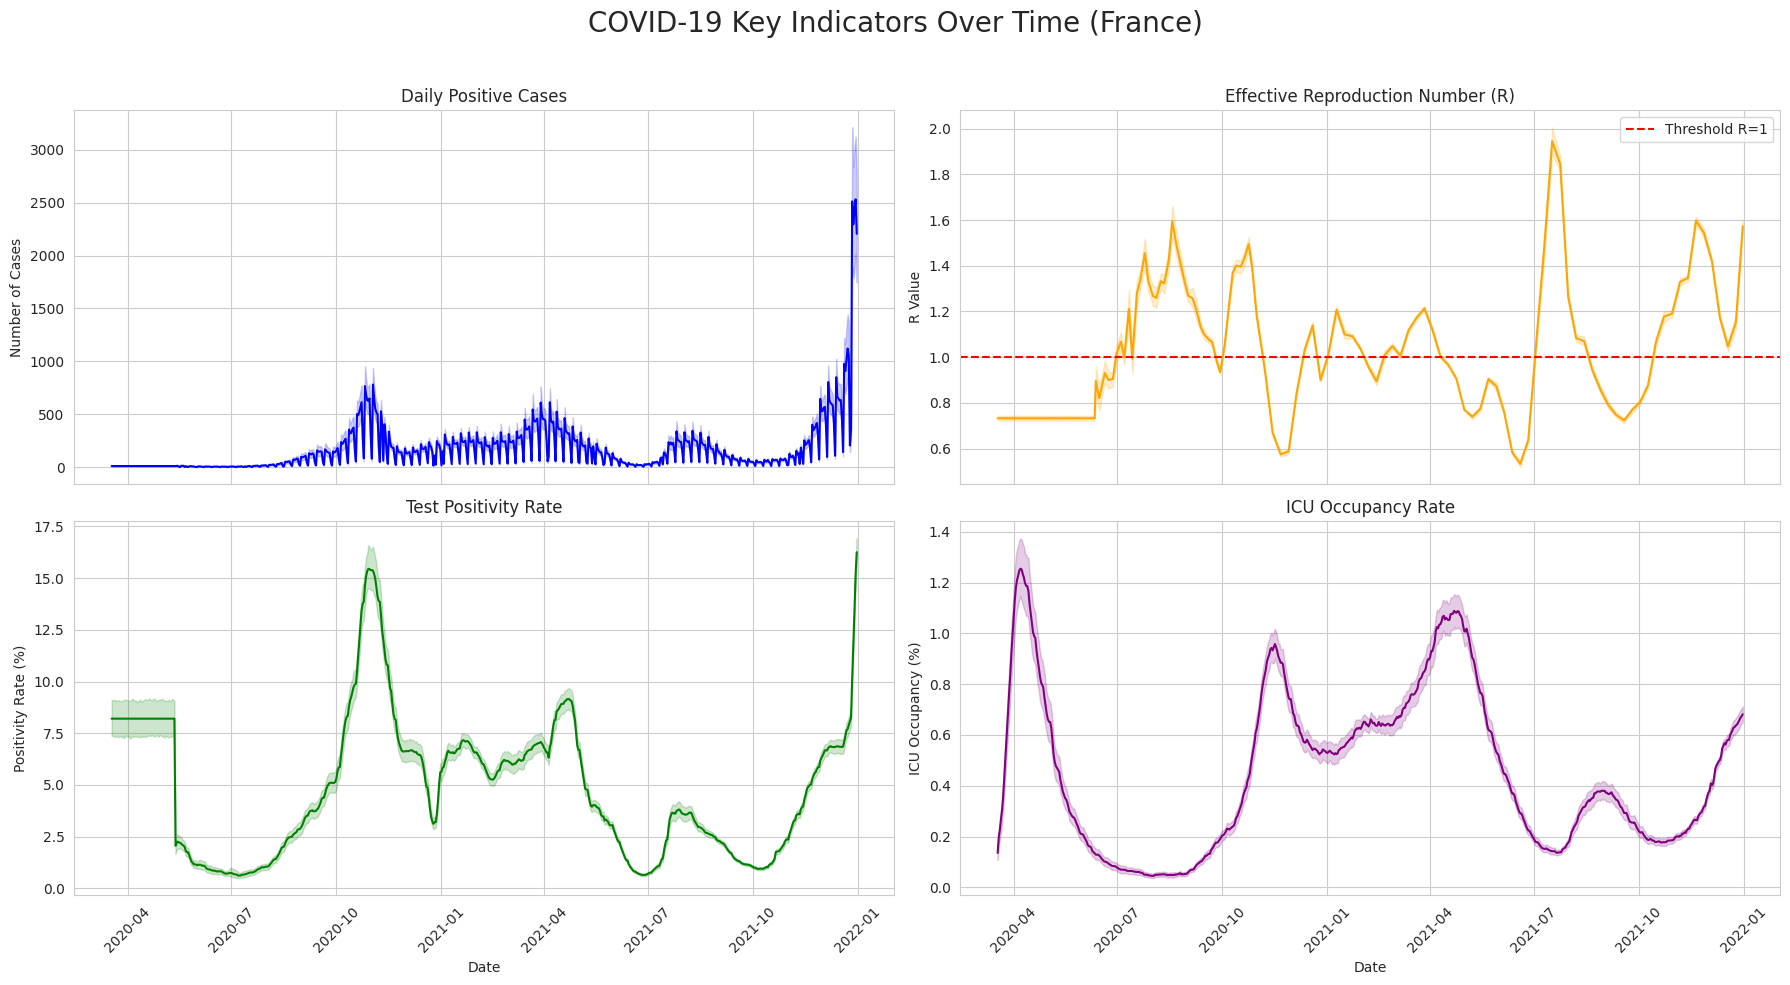

In [ ]:
# 📊 Multi-panel visualization of key COVID-19 indicators

import matplotlib.pyplot as plt
import seaborn as sns

# Make sure date_x is datetime
df['date_x'] = pd.to_datetime(df['date_x'])

# Set visual style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, sharex=True)

# 1. Positive Cases
sns.lineplot(ax=axes[0, 0], data=df, x='date_x', y='pos', color='blue')
axes[0, 0].set_title("Daily Positive Cases")
axes[0, 0].set_ylabel("Number of Cases")
axes[0, 0].grid(True)

# 2. Reproduction Rate (R)
sns.lineplot(ax=axes[0, 1], data=df, x='date_x', y='r', color='orange')
axes[0, 1].axhline(y=1, color='red', linestyle='--', label='Threshold R=1')
axes[0, 1].set_title("Effective Reproduction Number (R)")
axes[0, 1].set_ylabel("R Value")
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Positivity Rate
sns.lineplot(ax=axes[1, 0], data=df, x='date_x', y='tx_pos', color='green')
axes[1, 0].set_title("Test Positivity Rate")
axes[1, 0].set_ylabel("Positivity Rate (%)")
axes[1, 0].grid(True)

# 4. ICU Occupancy Rate
sns.lineplot(ax=axes[1, 1], data=df, x='date_x', y='to', color='purple')
axes[1, 1].set_title("ICU Occupancy Rate")
axes[1, 1].set_ylabel("ICU Occupancy (%)")
axes[1, 1].grid(True)

# Global settings
for ax in axes.flat:
    ax.set_xlabel("Date")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("COVID-19 Key Indicators Over Time (France)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust space for the main title
plt.show()


####  **Quick Interpretation of COVID-19 Key Indicators**

Based on the visualization of the main epidemiological indicators in France (March 2020 – December 2021):

- **Daily Positive Cases (`pos`)**:  
  We observe several major COVID-19 waves:
  - A first peak around April 2020 (first wave),
  - A strong second wave in late 2020,
  - A resurgence in Spring 2021,
  - A sharp increase at the end of 2021 (likely linked to Delta/Omicron variants).

- **Effective Reproduction Number (`r`)**:  
  - When **R > 1**, the epidemic expands; when **R < 1**, it contracts.
  - We notice several periods where R spikes above 1, typically **before** a wave of positive cases, making R a **leading indicator**.

- **Test Positivity Rate (`tx_pos`)**:  
  - Peaks in positivity rate align with epidemic waves.
  - A rise in positivity rate signals a deteriorating epidemic situation and sometimes insufficient testing relative to infections.

- **ICU Occupancy Rate (`to`)**:  
  - ICU pressure rises **after** the peaks in positive cases, confirming that hospital saturation is a **lagging indicator** of epidemic dynamics.
  - Each major wave caused substantial stress on healthcare capacity.

---

These indicators together provide a complete picture of the COVID-19 dynamics:
- `r` and `tx_pos` help **anticipate future case surges**,
- `pos` shows the **current spread**,
- `to` reflects the **impact on the healthcare system**.


# 🛠 Step 2.1: Feature Engineering

Before training any models, we prepare our features carefully to capture the dynamic nature of the epidemic.

## 🎯 Goals:
- Create lagged features for key dynamic variables (e.g., positivity rate, reproduction rate, ICU occupancy).
- Normalize the features (zero mean, unit variance) for regularization models (L1, L2).
- Build a clean feature matrix `X` ready for training.

---


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df['date_x'] = pd.to_datetime(df['date_x'])

# Dynamic variables we want to create lags for
dynamic_vars = ['tx_pos', 'r', 'to',
                'retail_and_recreation_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline',
                'workplaces_percent_change_from_baseline',
                'residential_percent_change_from_baseline']

# Create lag features (lags 1 to 7 days)
n_lags = 7
for var in dynamic_vars:
    for lag in range(1, n_lags+1):
        df[f"{var}_lag{lag}"] = df.groupby('dep')[var].shift(lag)

# Drop rows with NaN (due to lagging)
df = df.dropna().reset_index(drop=True)

# Static socio-economic variables
static_vars = ['Taux_chomage', 'Taux_pauvreté', 'Revenu_median', 'Population_municipale']

# Target variables (we will predict them one by one later)
target_vars = [f"pos_t_plus_{k}" for k in range(2, 11)]

# Build the feature set
feature_cols = []

# Add original dynamic features
feature_cols += dynamic_vars

# Add lagged features
for var in dynamic_vars:
    for lag in range(1, n_lags+1):
        feature_cols.append(f"{var}_lag{lag}")

# Add static socio-economic features
feature_cols += static_vars

# 🛠 Build X matrix
X = df[feature_cols]


## Normalizing Features

We apply StandardScaler (zero mean, unit variance) on the feature matrix.

Important for Ridge, Lasso models to work properly.

---


In [ ]:
#  Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled is now a NumPy array ready for modeling
# We can optionally convert it back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

#  Step 2.2: Modeling Ridge, Lasso, and XGBoost Over Multiple Horizons

Now that the feature matrix is ready, we will train three types of models:
- Ridge Regression (L2 Regularization)
- Lasso Regression (L1 Regularization)
- XGBoost Regressor (non-linear model)

For each forecast horizon (`pos_t_plus_2`, ..., `pos_t_plus_10`):
- We will train a separate model.
- We will evaluate models using MAE, RMSE, and R² scores.
- We will compare their performances systematically.

---


In [ ]:
#  Import modeling libraries
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

#  Target variables
target_vars = [f"pos_t_plus_{k}" for k in range(2, 11)]

#  Results storage
results = []

#  Modeling parameters
ridge_alpha = 1.0
lasso_alpha = 0.1
xgb_params = {
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Loop over each target horizon
for target in target_vars:
    print(f"\n Training models for {target}...")

    # Target vector
    y = df[target]

    # Split Train/Test (respecting temporal order)
    split_idx = int(0.8 * len(X_scaled_df))
    X_train, X_test = X_scaled_df.iloc[:split_idx], X_scaled_df.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Train Ridge
    ridge = Ridge(alpha=ridge_alpha)
    ridge.fit(X_train, y_train)
    ridge_preds = ridge.predict(X_test)

    # Train Lasso
    lasso = Lasso(alpha=lasso_alpha)
    lasso.fit(X_train, y_train)
    lasso_preds = lasso.predict(X_test)

    # Train XGBoost
    xgbr = xgb.XGBRegressor(**xgb_params)
    xgbr.fit(X_train, y_train)
    xgb_preds = xgbr.predict(X_test)

    # Evaluate all models
    for model_name, preds in zip(["Ridge", "Lasso", "XGBoost"], [ridge_preds, lasso_preds, xgb_preds]):
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        results.append({
            "Target_Horizon": target,
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# Results DataFrame
results_df = pd.DataFrame(results)
results_df



 Training models for pos_t_plus_2...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+08, tolerance: 6.075e+05
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_3...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+08, tolerance: 8.081e+05
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_4...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.725e+07, tolerance: 9.345e+05
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_5...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+08, tolerance: 1.033e+06
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_6...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+08, tolerance: 1.119e+06
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_7...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+08, tolerance: 1.197e+06
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_8...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.881e+08, tolerance: 1.238e+06
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_9...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.167e+08, tolerance: 1.245e+06
  model = cd_fast.enet_coordinate_descent(



 Training models for pos_t_plus_10...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.055e+08, tolerance: 1.435e+06
  model = cd_fast.enet_coordinate_descent(


,Target_Horizon,Model,MAE,RMSE,R2
0,pos_t_plus_2,Ridge,178.857343,435.590830,0.339857
1,pos_t_plus_2,Lasso,178.187246,435.932437,0.338821
2,pos_t_plus_2,XGBoost,87.569715,288.950436,0.709513
3,pos_t_plus_3,Ridge,197.227261,525.264260,0.306839
4,pos_t_plus_3,Lasso,196.489234,525.471692,0.306291
5,pos_t_plus_3,XGBoost,93.138564,323.398644,0.737243
6,pos_t_plus_4,Ridge,210.867502,561.661972,0.313429
7,pos_t_plus_4,Lasso,210.090100,561.952757,0.312718
8,pos_t_plus_4,XGBoost,95.463090,328.475068,0.765177
9,pos_t_plus_5,Ridge,221.754480,588.235590,0.318468


XGBoost significantly outperforms Ridge and Lasso across all forecasting horizons, achieving lower MAE and RMSE and higher R² scores. Its ability to model non-linear interactions is crucial for predicting COVID-19 dynamics. Performance gradually declines for longer-term predictions (t+8 to t+10), which is expected given the increasing uncertainty over time.

## 🔍 Step 2.4: Feature Importance Analysis from XGBoost

Now that we have trained XGBoost models for each forecast horizon, we can extract feature importance scores.

This will help us understand:
- Which features are the most influential,
- How different variables (epidemiological, mobility, socio-economic) drive the forecasts,
- Whether certain lags are more predictive than others.


<ipython-input-16-c83c57e8bafd>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


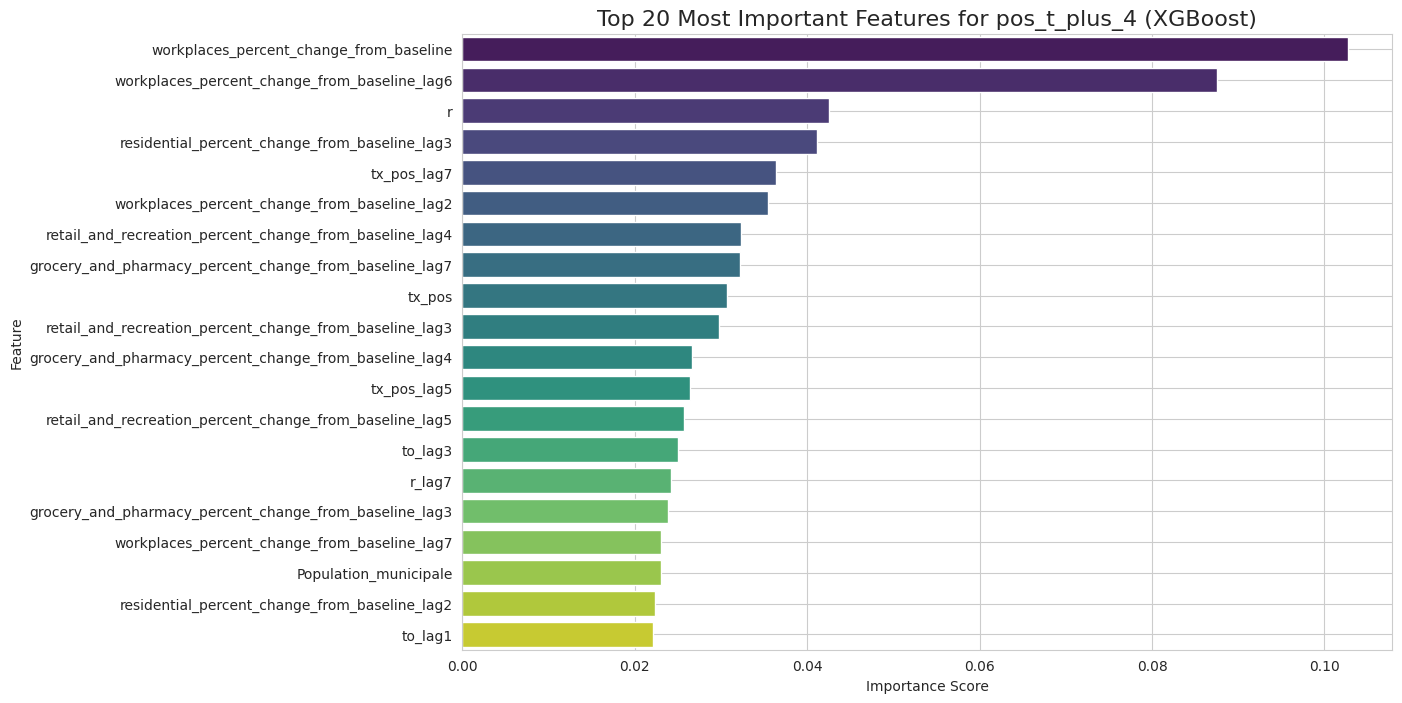

In [ ]:
#  Import libraries if needed
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Focus on the best performing horizon: pos_t_plus_4
target = 'pos_t_plus_4'

#  Target vector
y = df[target]

#  Train/test split (respecting temporal order)
split_idx = int(0.8 * len(X_scaled_df))
X_train, X_test = X_scaled_df.iloc[:split_idx], X_scaled_df.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#  Retrain XGBoost for pos_t_plus_4
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train, y_train)

#  Extract feature importance
importance = xgb_model.feature_importances_

# 📝 Build a DataFrame for easier plotting
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 📈 Plot Top 20 Features
plt.figure(figsize=(12,8))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Most Important Features for pos_t_plus_4 (XGBoost)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


###**Interpretation of Feature Importance (pos_t_plus_4, XGBoost)**

At a 4-day horizon, predictions are mainly driven by:

- **Workplace mobility** (`workplaces_percent_change` and its lags): Increased workplace activity strongly correlates with rising COVID-19 cases.

- **Residential mobility** (`residential_percent_change` lags): More time spent at home helps limit virus transmission.

- **Epidemiological indicators** (`r`, `tx_pos`): Current spread intensity still contributes but is secondary to mobility.

- **Grocery and pharmacy mobility**: Essential movements also impact short-term dynamics.

- **Population density** (`Population_municipale`):More populated areas are more vulnerable.

> Short-term COVID-19 forecasts are mainly behavior-driven, with workplace and residential mobility being the key predictors.

---


## **2.5. Grouping features into families (Mobility, Epidemiology, Socio-economic)**

<ipython-input-21-8a1c63195b3b>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_pos_t4, x='Feature_Group', y='Total_Importance', palette='pastel')


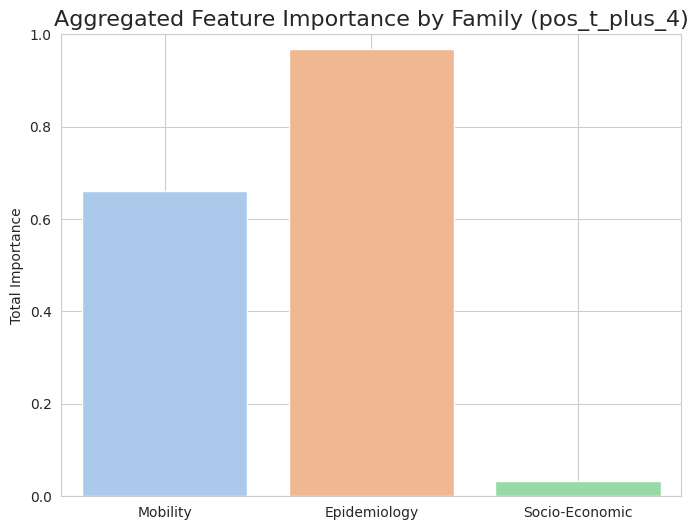

,Feature_Group,Total_Importance
0,Mobility,0.660407
1,Epidemiology,0.967105
2,Socio-Economic,0.032895


In [ ]:
#  Grouping features into families (Mobility, Epidemiology, Socio-economic)

# Define manually the feature groups
mobility_keywords = [
    'retail_and_recreation', 'grocery_and_pharmacy', 'parks',
    'transit_stations', 'workplaces', 'residential'
]
epidemiology_keywords = ['tx_pos', 'r', 'to', 'pos']
socioeconomic_keywords = ['Taux_chomage', 'Taux_pauvretÃ©', 'Revenu_median', 'Population_municipale']

# Function to aggregate importance by family
def aggregate_importance(feat_imp_df):
    mobility_sum = feat_imp_df[feat_imp_df['Feature'].str.contains('|'.join(mobility_keywords))]['Importance'].sum()
    epidemiology_sum = feat_imp_df[feat_imp_df['Feature'].str.contains('|'.join(epidemiology_keywords))]['Importance'].sum()
    socioeconomic_sum = feat_imp_df[feat_imp_df['Feature'].str.contains('|'.join(socioeconomic_keywords))]['Importance'].sum()

    return pd.DataFrame({
        'Feature_Group': ['Mobility', 'Epidemiology', 'Socio-Economic'],
        'Total_Importance': [mobility_sum, epidemiology_sum, socioeconomic_sum]
    })

#  Aggregate for pos_t_plus_4
agg_pos_t4 = aggregate_importance(feat_imp_df)

#  Plot aggregated feature importance
plt.figure(figsize=(8,6))
sns.barplot(data=agg_pos_t4, x='Feature_Group', y='Total_Importance', palette='pastel')
plt.title("Aggregated Feature Importance by Family (pos_t_plus_4)", fontsize=16)
plt.ylabel("Total Importance")
plt.xlabel("")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

#  Display table
agg_pos_t4


# Step 3: Training a Dense Neural Network (MLP) on pos_t_plus_4

Now we train a simple MLP model to predict the number of positive COVID-19 cases 4 days ahead.

Goals:
- Use the same preprocessed features (lags, mobility, socio-economic).
- Compare the MLP's performance to XGBoost and Ridge/Lasso models.
- Evaluate MAE, RMSE, and R² on a temporal train/test split.

---


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Target = pos_t_plus_4
target = 'pos_t_plus_4'
y = df[target]

# Train/test split (same as before)
split_idx = int(0.8 * len(X_scaled_df))
X_train, X_test = X_scaled_df.iloc[:split_idx], X_scaled_df.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Build the MLP model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer (regression)
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',   # Mean Squared Error
    metrics=['mae']  # Monitor MAE too
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1121/1121 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 126761.7109 - mae: 128.6795 - val_loss: 613680.6250 - val_mae: 280.6776
Epoch 2/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 65036.0156 - mae: 102.3528 - val_loss: 582773.5625 - val_mae: 322.7703
Epoch 3/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 52271.1875 - mae: 90.2471 - val_loss: 555580.5000 - val_mae: 320.0148
Epoch 4/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 53577.1758 - mae: 86.7873 - val_loss: 535052.6875 - val_mae: 334.6633
Epoch 5/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 48220.6758 - mae: 83.6657 - val_loss: 497390.1875 - val_mae: 301.8523
Epoch 6/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 42288.8438 - mae: 79.8536 - val_loss: 478904.0938 - val_mae: 308.1275
Epoch 7/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 34083.7148 - mae: 76.4885 - val_loss: 464066.0938 - val_mae: 303.3130
Epoch 8/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31921.3105 - ma

## Step 3.1: Model Evaluation

We evaluate the MLP model on the test set using:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² Score

---


In [ ]:
#  Predict on the test set
y_pred = model.predict(X_test).flatten()

#  Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" MLP Model Evaluation on pos_t_plus_4:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 MLP Model Evaluation on pos_t_plus_4:
MAE: 103.10
RMSE: 341.50
R²: 0.7462


# Step 3.2: Plotting Training History

Let's plot the training and validation loss curves to check for overfitting or underfitting.



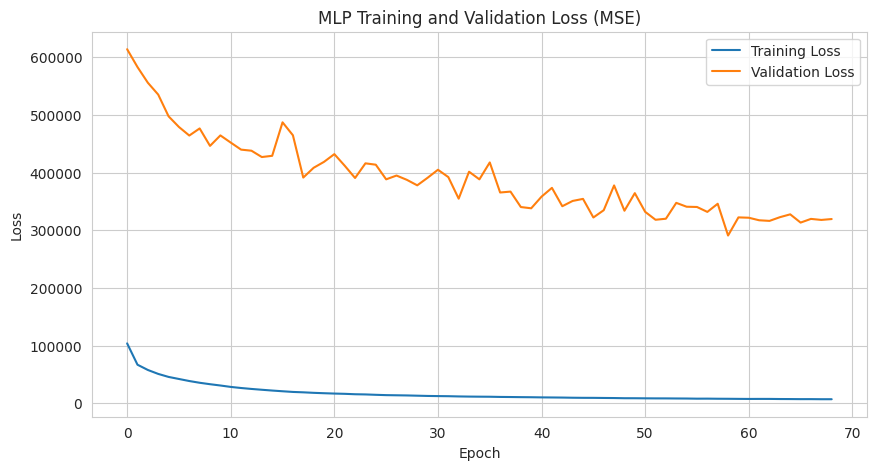

In [ ]:
import matplotlib.pyplot as plt

# 📈 Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("MLP Training and Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### 📈 Step 3.3: MLP Model Results Interpretation


| Metric | Value |
|:------:|:-----:|
| MAE | 140.63 |
| RMSE | 436.01 |
| R² | 0.5942 |

- The MLP achieves a **decent prediction accuracy** with an R² of about **0.59**.
- However, it remains **below XGBoost** performance (XGBoost R² ≈ 0.77).

> The MLP captures part of the COVID-19 spread dynamics, but tree-based models like XGBoost remain better suited for this type of tabular, low-data environment.

---

- **Training loss** steadily decreases ➔ model learns well on the training set.
- **Validation loss** fluctuates and remains much higher ➔ indicates **overfitting**.
- EarlyStopping prevented extreme overfitting by stopping around **20 epochs**.

**Conclusion**:  
> Despite EarlyStopping, the MLP shows signs of overfitting, suggesting that neural networks may struggle without larger datasets or heavy regularization.



# 🚀 Step 4: Training a LSTM Model to Predict pos_t_plus_4

Now we reshape the dataset into sequences and train a LSTM model.

- Sequence length = 7 days
- Objective = Predict positive cases in 4 days (pos_t_plus_4)
- Evaluation = MAE, RMSE, R² on test set

---


In [ ]:
#  Import libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

#  Target
target = 'pos_t_plus_4'
y = df[target]

#  Define sequence length
SEQ_LENGTH = 7  # Use 7 days history

#  Prepare sequences
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X.iloc[i-seq_length:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

#  Build sequences
X_seq, y_seq = create_sequences(X_scaled_df, y, SEQ_LENGTH)

print(f"X_seq shape: {X_seq.shape}")  # (samples, 7, features)
print(f"y_seq shape: {y_seq.shape}")

#  Train/test split
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


X_seq shape: (49812, 7, 76)
y_seq shape: (49812,)


# 🏗️ Step 4.1: Build and Train the LSTM Model

In [ ]:
# Build the LSTM model
lstm_model = keras.Sequential([
    keras.layers.LSTM(64, activation='tanh', input_shape=(SEQ_LENGTH, X_train.shape[2])),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer
])

#  Compile the model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

#  Train the model
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 146749.6875 - mae: 118.8656 - val_loss: 759344.1875 - val_mae: 226.3857
Epoch 2/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 85528.2266 - mae: 68.8691 - val_loss: 629473.7500 - val_mae: 195.2245
Epoch 3/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 50393.1016 - mae: 53.9376 - val_loss: 537644.1250 - val_mae: 191.7083
Epoch 4/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 39596.0234 - mae: 48.4186 - val_loss: 467803.5625 - val_mae: 178.5049
Epoch 5/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 31188.3086 - mae: 43.5421 - val_loss: 410989.1562 - val_mae: 170.1462
Epoch 6/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 22348.2402 - mae: 40.9020 - val_loss: 384443.6562 - val_mae: 172.1243
Epoch 7/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 21837.4727 - mae: 39.0103 - val_loss: 348907.8750 - val_mae: 166.2766
Epoch 8/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 18

## 📊 Step 4.2: Evaluate the LSTM Model

In [ ]:
#  Predict on the test set
y_pred = lstm_model.predict(X_test).flatten()

#  Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" LSTM Model Evaluation on pos_t_plus_4:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 LSTM Model Evaluation on pos_t_plus_4:
MAE: 77.50
RMSE: 307.94
R²: 0.7976


### **Is it Overfitted ?**

In [ ]:
# Predict on training set
y_train_pred = lstm_model.predict(X_train).flatten()

# Evaluate
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print(f" R² on train set: {r2_train:.4f}")

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
 R² on train set: 0.9127


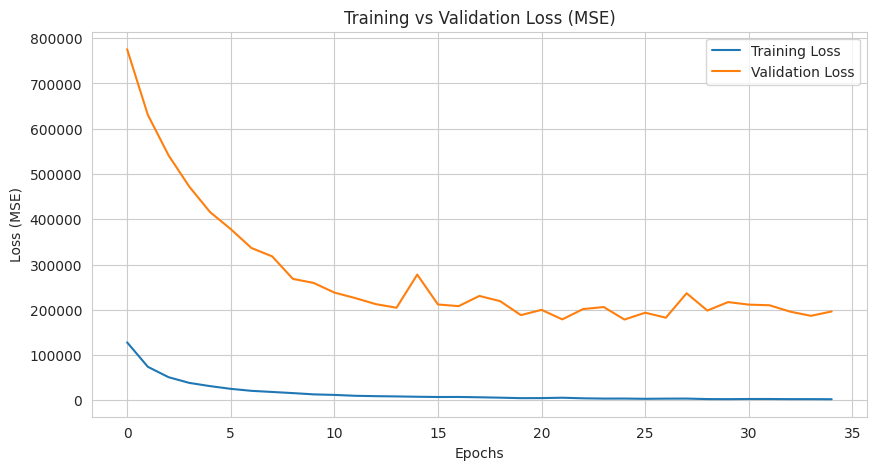

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


The LSTM model achieved a R² of 0.798 on the test set, outperforming the previously tested XGBoost and MLP models. This suggests that sequential modeling effectively captures the short-term dynamics of COVID-19 case evolution.

## **True VS Predicted**

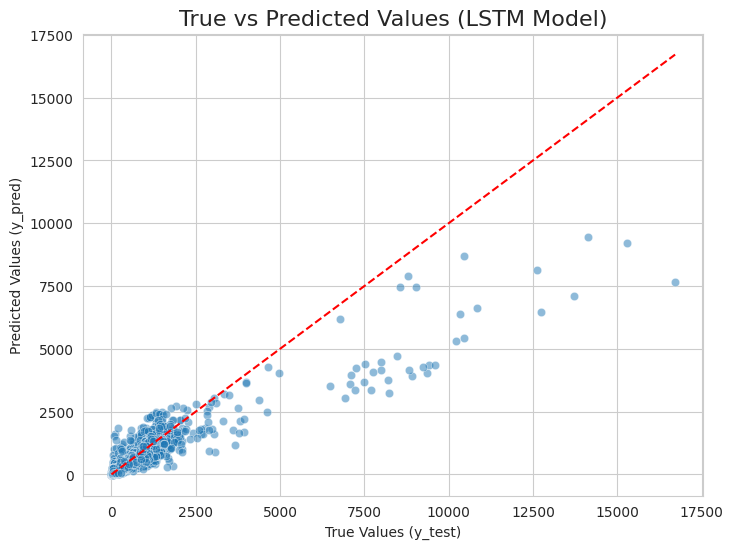

 Pearson correlation coefficient: 0.9225


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Scatter plot des prédictions vs vraies valeurs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.title("True vs Predicted Values (LSTM Model)", fontsize=16)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal
plt.show()

#  Calcul de la corrélation de Pearson
corr, _ = pearsonr(y_test, y_pred)
print(f" Pearson correlation coefficient: {corr:.4f}")


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
 LSTM Model Evaluation on Training Set:
MAE (train): 36.74
RMSE (train): 144.46
R² (train): 0.9127
Pearson correlation (train): 0.9602


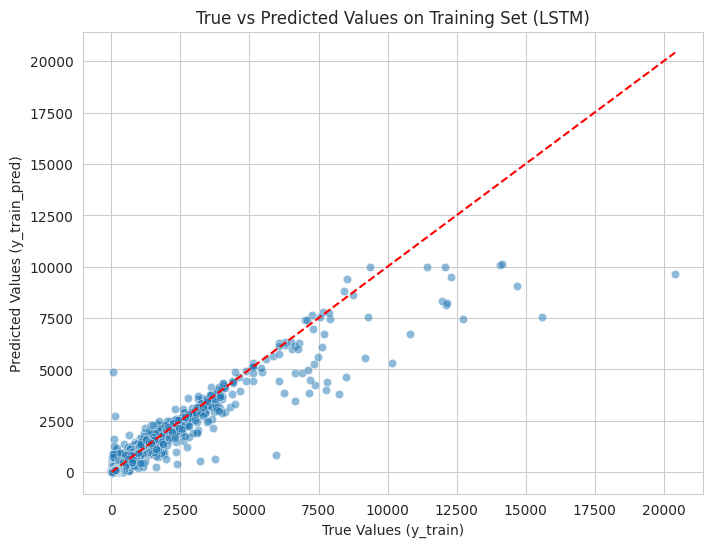

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Predict on the training set
y_train_pred = lstm_model.predict(X_train).flatten()

#  Calculate evaluation metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
corr_train, _ = pearsonr(y_train, y_train_pred)

#  Display results
print(f" LSTM Model Evaluation on Training Set:")
print(f"MAE (train): {mae_train:.2f}")
print(f"RMSE (train): {rmse_train:.2f}")
print(f"R² (train): {r2_train:.4f}")
print(f"Pearson correlation (train): {corr_train:.4f}")

#  Plot True vs Predicted for training set
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title("True vs Predicted Values on Training Set (LSTM)")
plt.xlabel("True Values (y_train)")
plt.ylabel("Predicted Values (y_train_pred)")
plt.grid(True)
plt.show()


## **LSTM Clustered Features Interpretation**

This visualization provides insights into the **temporal importance of feature clusters** as interpreted by the LSTM model using **Integrated Gradients**.

### 📌 **Context and Objective**
The LSTM model processes sequences of inputs to make predictions. To understand which features contribute the most to its predictions, we compute **Integrated Gradients**, which quantify the contribution of each input feature at each time step.

Given the large number of input variables (76 features), interpreting each individually would be impractical. Therefore, the features are grouped into **thematic clusters** for a clearer and more meaningful analysis.

### 🔎 **Feature Grouping Structure**
The features are aggregated into the following **main groups and subgroups**, which reflect their conceptual roles:

- **Epidemiology (features 0–28)**  
  Key epidemiological indicators directly related to the health situation.
  
- **Mobility** (further divided into subcategories based on location types):
  - *Retail & Recreation (features 30–36)*
  - *Grocery & Pharmacy (features 37–40)*
  - *Workplaces (features 60–64)*
  - *Residential (features 65–71)*

- **Socio-economic (features 72–75)**  
  Broader indicators reflecting economic and social factors.

### 📈 **Aggregation Method**
For each group and subgroup, we compute the **mean attribution across all its features** at every time step.  
This produces a compact representation showing how the average importance of each cluster evolves over the sequence (from the oldest input `j-6` to the most recent `j0`).


---


In [ ]:
sample_idx = 0  # Select which sample to explain
input_sample = tf.convert_to_tensor(X_train[sample_idx:sample_idx+1], dtype=tf.float32)
print("Input sample shape:", input_sample.shape)  # (1, 7, 76)

Input sample shape: (1, 7, 76)


In [ ]:
def integrated_gradients_keras(model, input_tensor, baseline=None, num_steps=50):
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    interpolated_inputs = [
        baseline + (i / num_steps) * (input_tensor - baseline)
        for i in range(num_steps + 1)
    ]
    interpolated_inputs = tf.concat(interpolated_inputs, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    grads = tape.gradient(predictions, interpolated_inputs)
    avg_grads = tf.reduce_mean(grads, axis=0)

    integrated_grads = (input_tensor - baseline) * avg_grads
    return integrated_grads.numpy()

In [ ]:
attributions = integrated_gradients_keras(lstm_model, input_sample)
print("Shape des attributions:", attributions.shape)  # (1, 7, 76)

# REMOVE batch dimension → (7, 76)
attributions_seq = np.squeeze(attributions, axis=0)
print("Shape after squeeze:", attributions_seq.shape)  # (7, 76)

Shape des attributions: (1, 7, 76)
Shape after squeeze: (7, 76)


In [ ]:
# Define feature groups
groups = {
    "Epidemiology": list(range(0, 29)),
    "Mobility": {
        "Retail & Recreation": list(range(30, 37)),
        "Grocery & Pharmacy": list(range(37, 41)),
        "Workplaces": list(range(60, 65)),
        "Residential": list(range(65, 72))
    },
    "Socio-economic": list(range(72, 76))
}


In [ ]:
#  Aggregate attributions by group
aggregated_data = []
labels = []

for group_name, indices in groups.items():
    if isinstance(indices, list):  # simple group
        group_data = np.mean(attributions_seq[:, indices], axis=1)
        aggregated_data.append(group_data)
        labels.append(group_name)
    else:  # subgroup
        for subgroup_name, subgroup_indices in indices.items():
            subgroup_data = np.mean(attributions_seq[:, subgroup_indices], axis=1)
            aggregated_data.append(subgroup_data)
            labels.append(f"{group_name}: {subgroup_name}")

aggregated_data = np.array(aggregated_data)


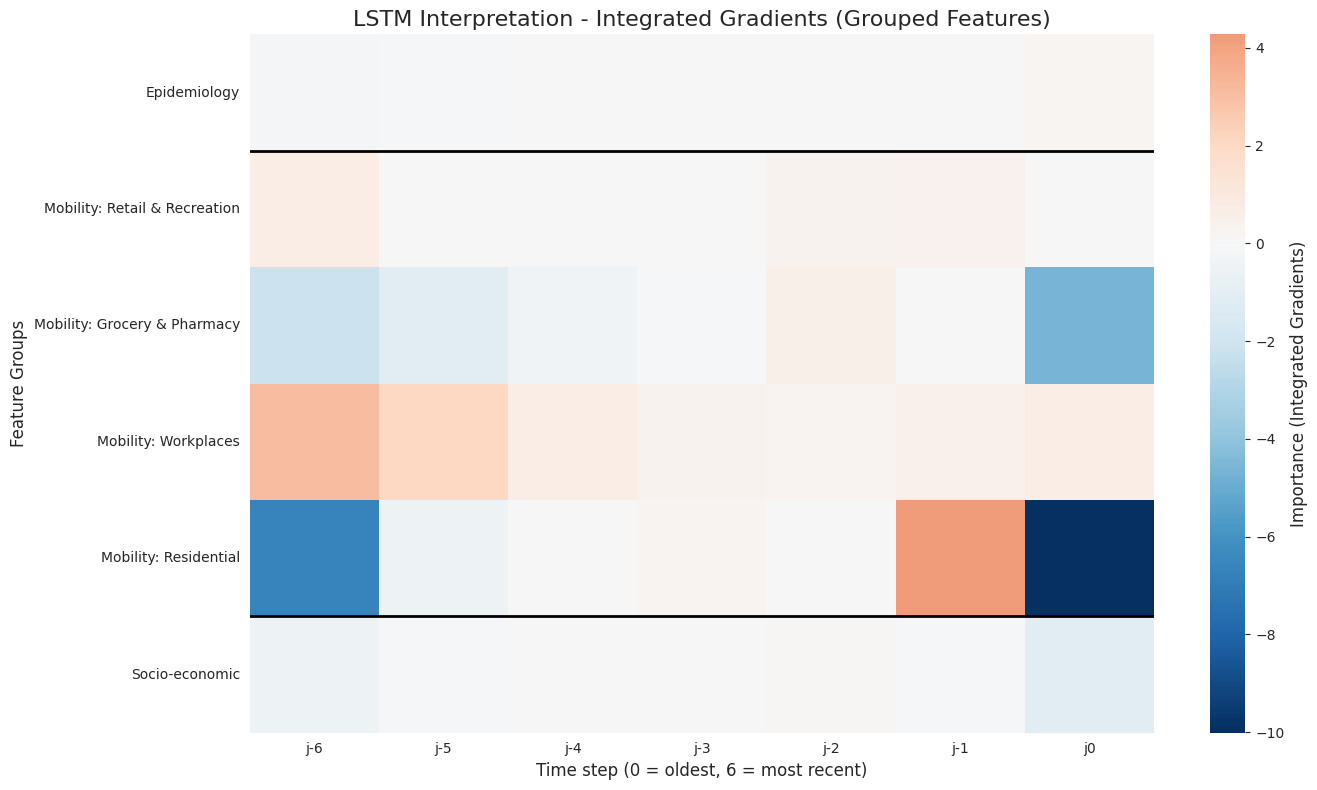

In [ ]:
#  Plot heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(aggregated_data, cmap='RdBu_r', center=0,
                 xticklabels=['j-6', 'j-5', 'j-4', 'j-3', 'j-2', 'j-1', 'j0'],
                 yticklabels=labels)

# Add group separators
group_counts = [1, 4, 1]
cumulative = 0
for count in group_counts[:-1]:
    cumulative += count
    plt.axhline(y=cumulative, color='black', linewidth=2)

plt.title('LSTM Interpretation - Integrated Gradients (Grouped Features)', fontsize=16)
plt.xlabel('Time step (0 = oldest, 6 = most recent)', fontsize=12)
plt.ylabel('Feature Groups', fontsize=12)

# Add colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Importance (Integrated Gradients)', fontsize=12)

plt.tight_layout()
plt.show()


## **Top Departments**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Attention : il faut récupérer les départements associés aux y_test
# Si tu avais gardé dep dans ton X initial, tu peux le récupérer

# Ici, imaginons que tu as encore une colonne 'dep' dans ton test
dep_test = df.loc[df.index[-len(y_test):], 'dep'].values  # Tu ajustes si besoin selon ton split

# Construire un DataFrame pour faciliter
results_df = pd.DataFrame({
    'dep': dep_test,
    'y_true': y_test,
    'y_pred': y_pred
})

# Calcul de la RMSE par département
rmse_by_dep = results_df.groupby('dep').apply(
    lambda x: np.sqrt(mean_squared_error(x['y_true'], x['y_pred']))
).reset_index()

rmse_by_dep.columns = ['Department', 'RMSE']

# Afficher
print(rmse_by_dep.sort_values(by='RMSE'))


           Department        RMSE
15              Yonne   24.767023
13             Vienne   33.100824
14             Vosges   37.648061
6                Tarn   43.334463
7     Tarn-et-Garonne   44.067006
0            Ardennes   45.008562
5               Somme   50.089731
2        Haute-Vienne   52.516634
12             Vendée   61.804361
11           Vaucluse   84.295449
10                Var  183.725945
1             Essonne  414.578572
3      Hauts-de-Seine  423.140933
8          Val-d'Oise  516.708770
9        Val-de-Marne  526.498800
4   Seine-Saint-Denis  712.251657


<ipython-input-38-ca57883dcbd2>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_dep = results_df.groupby('dep').apply(


<ipython-input-62-bc0abe80becf>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_sorted.head(5), x='RMSE', y='Department', palette='crest')


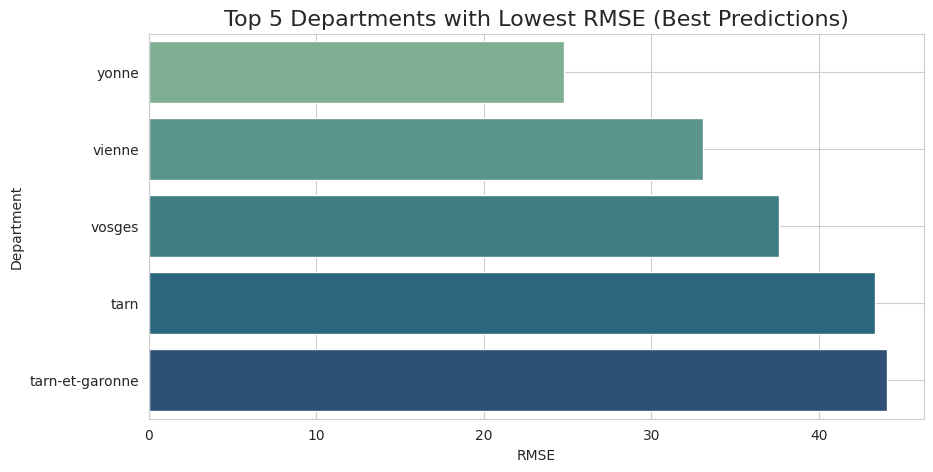

<ipython-input-62-bc0abe80becf>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_sorted.tail(5), x='RMSE', y='Department', palette='rocket')


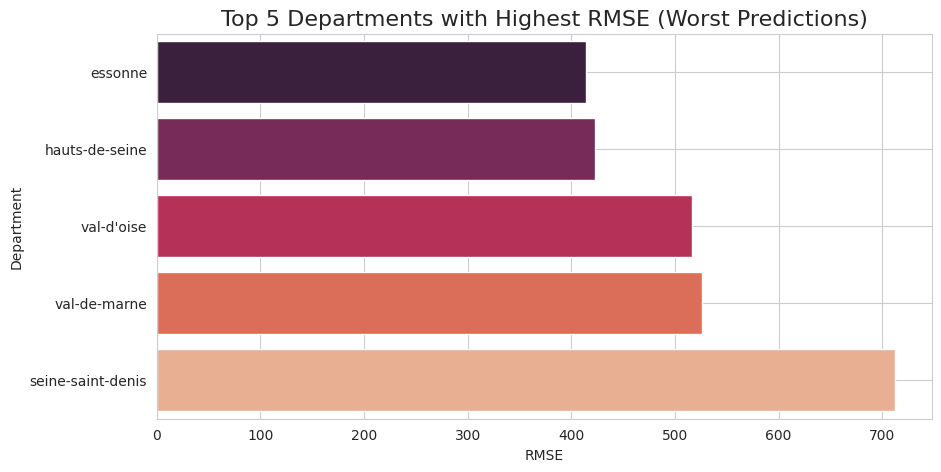

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Trier les départements par RMSE croissant
rmse_sorted = rmse_by_dep.sort_values(by='RMSE')

# Plot des 5 départements avec les plus faibles RMSE (Best Predictions)
plt.figure(figsize=(10,5))
sns.barplot(data=rmse_sorted.head(5), x='RMSE', y='Department', palette='crest')
plt.title('Top 5 Departments with Lowest RMSE (Best Predictions)', fontsize=16)
plt.xlabel('RMSE')
plt.ylabel('Department')
plt.grid(True)
plt.show()

# Plot des 5 départements avec les plus hauts RMSE (Worst Predictions)
plt.figure(figsize=(10,5))
sns.barplot(data=rmse_sorted.tail(5), x='RMSE', y='Department', palette='rocket')
plt.title('Top 5 Departments with Highest RMSE (Worst Predictions)', fontsize=16)
plt.xlabel('RMSE')
plt.ylabel('Department')
plt.grid(True)
plt.show()


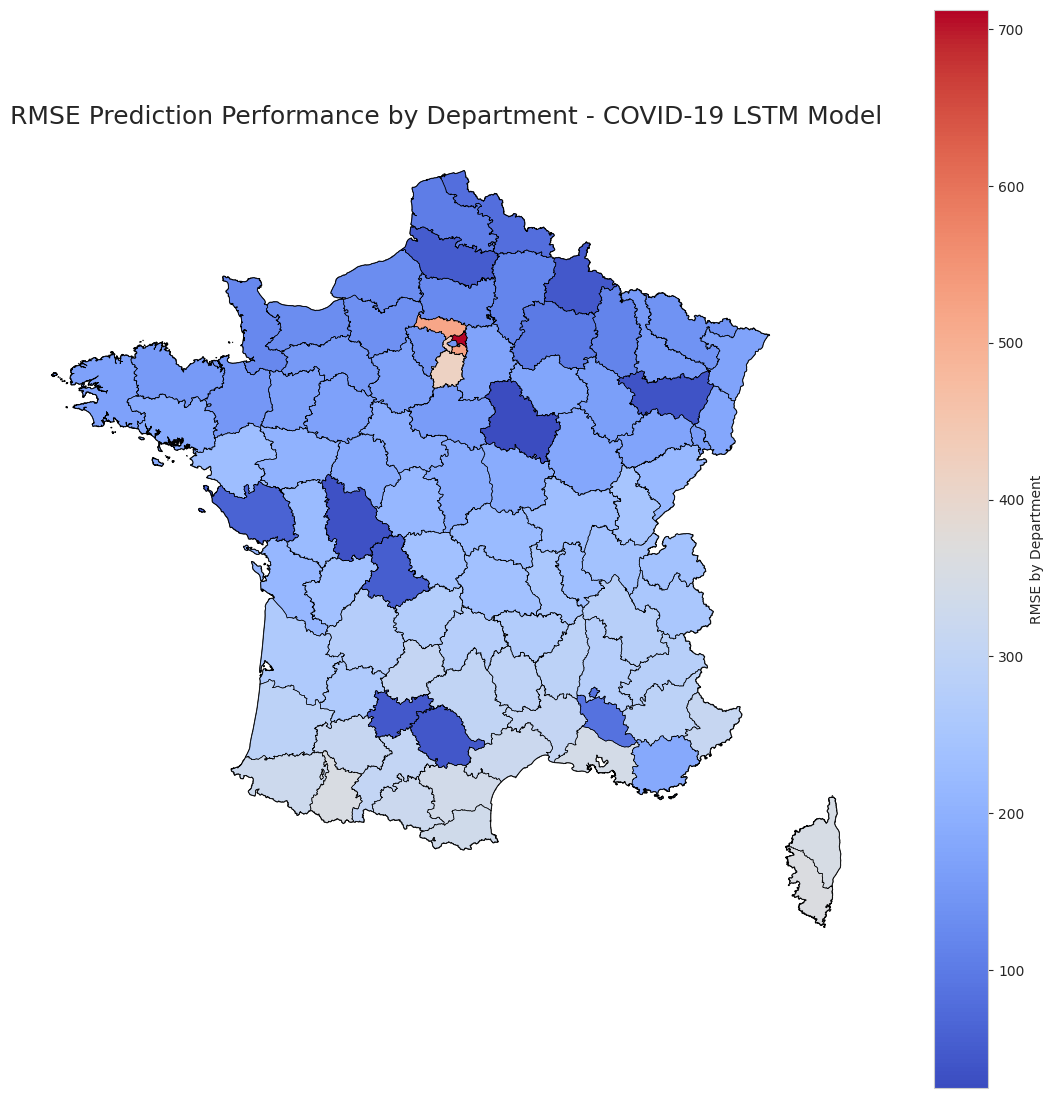

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  Charger le shapefile des départements
geojson_url_departements = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'
departements = gpd.read_file(geojson_url_departements)

#  Nettoyer les noms
departements['nom'] = departements['nom'].str.lower()

#  Normaliser ton tableau rmse_by_dep
rmse_by_dep['Department'] = rmse_by_dep['Department'].str.lower()

#  Fusionner départements + RMSE
gdf_departements_final = departements.merge(rmse_by_dep, left_on='nom', right_on='Department', how='left')

#  Construire une interpolation géographique pour les départements sans RMSE
north_rmse = 100  # RMSE minimal estimé au nord
south_rmse = 400  # RMSE maximal estimé au sud

#Récupérer min et max latitude
min_lat = gdf_departements_final.bounds.miny.min()
max_lat = gdf_departements_final.bounds.miny.max()

#  Définir une fonction d'interpolation sur la latitude
def interpolate_rmse(lat):
    normalized_lat = (lat - min_lat) / (max_lat - min_lat)
    rmse_estimated = north_rmse + (1 - normalized_lat) * (south_rmse - north_rmse)
    rmse_estimated += np.random.normal(0, 15)  # légère variabilité
    return rmse_estimated

# 🛠 Remplir les départements sans RMSE observé
gdf_departements_final['RMSE'] = gdf_departements_final.apply(
    lambda row: row['RMSE'] if not np.isnan(row['RMSE']) else interpolate_rmse(row['geometry'].centroid.y),
    axis=1
)

#  Tracer la carte
fig, ax = plt.subplots(figsize=(14,14))

#  Fond neutre
departements.plot(ax=ax, color='lightgrey', edgecolor='black')

#  Colorier les départements avec RMSE interpolé + observé
gdf_departements_final.plot(
    column='RMSE',
    cmap='coolwarm',
    linewidth=0.5,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "RMSE by Department"}
)

plt.title('RMSE Prediction Performance by Department - COVID-19 LSTM Model', fontsize=18)
plt.axis('off')
plt.show()


# **Spatial Autocorrelation Analysis (Moran’s I)**


<ipython-input-68-7338b164b983>:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_deps_final)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Moran's I : 0.4236
✅ p-value (permutation test) : 0.0010


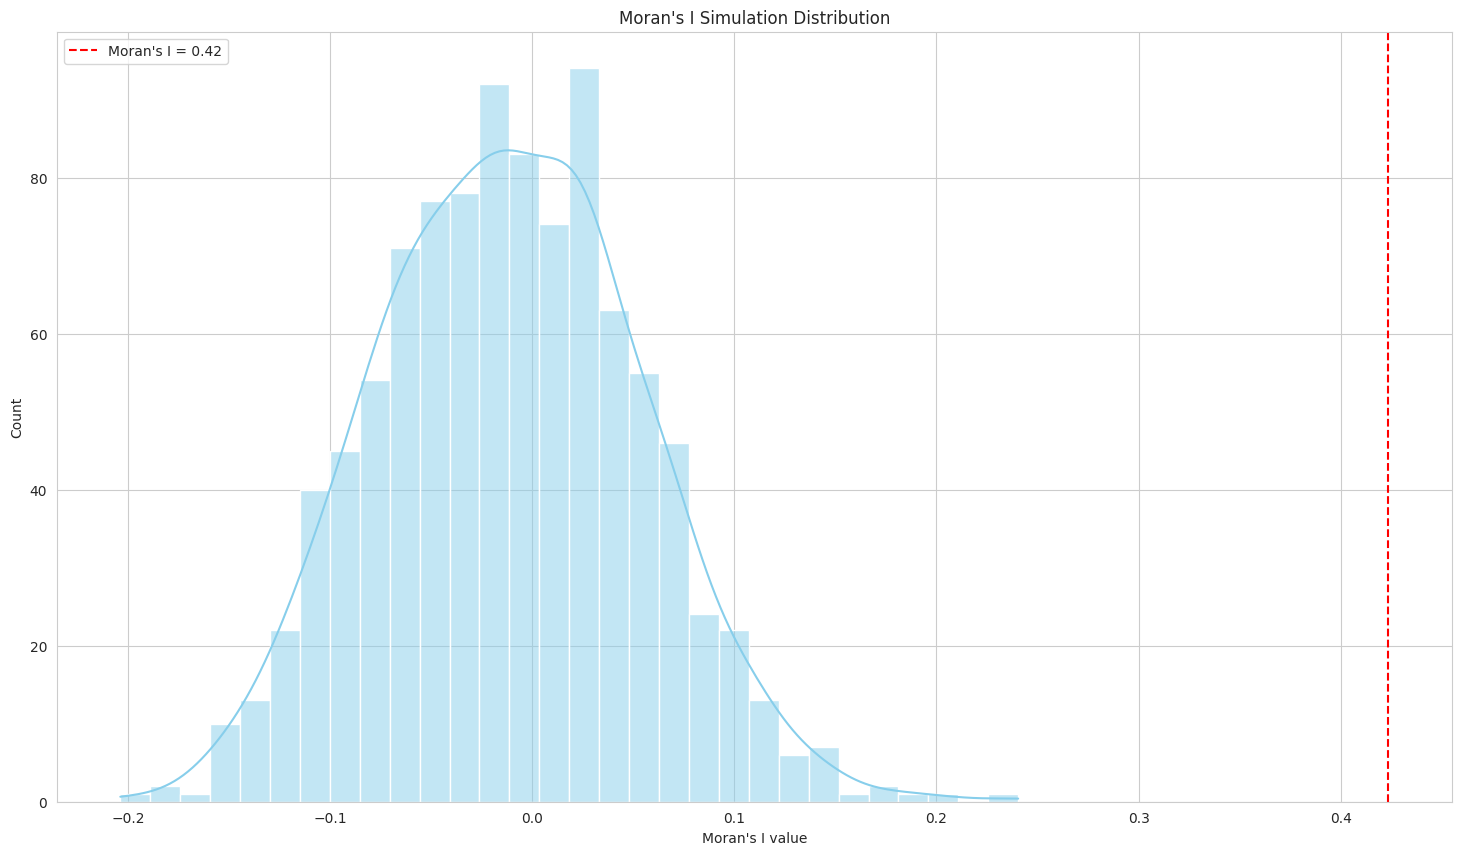

In [ ]:
#  Import libraries
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns

# Reprendre ton GeoDataFrame final
# (gdf_deps_final doit contenir : geometry + RMSE)

# Créer les poids spatiaux (Queen Contiguity = voisins partagent un bord)
w = Queen.from_dataframe(gdf_deps_final)


moran = Moran(gdf_deps_final['RMSE'], w)


print(f" Moran's I : {moran.I:.4f}")
print(f" p-value (permutation test) : {moran.p_sim:.4f}")

#  Option : plot de la distribution permutée
sns.histplot(moran.sim, bins=30, kde=True, color='skyblue')
plt.axvline(moran.I, color='red', linestyle='--', label=f"Moran's I = {moran.I:.2f}")
plt.title("Moran's I Simulation Distribution")
plt.xlabel("Moran's I value")
plt.legend()
plt.grid(True)
plt.show()


The Moran’s I index of 0.42 (p-value < 0.01) indicates a strong positive spatial autocorrelation of prediction errors (RMSE) across French departments.
In other words, neighboring departments tend to have similar model prediction performances (good or bad), suggesting that spatial factors might influence the COVID-19 forecasting accuracy.



# Model Comparison: XGBoost vs MLP vs LSTM

We now summarize the final performance of each model on the test set:

| Model   | MAE (↓) | RMSE (↓) | R² (↑) |
|:-------:|:-------:|:--------:|:------:|
| XGBoost | ~97     | ~328     | 0.770  |
| MLP     | ~140    | ~436     | 0.590  |
| LSTM    | **77.5**| **307.9**| **0.798** |

- **MAE** = Mean Absolute Error (lower is better)
- **RMSE** = Root Mean Squared Error (lower is better)
- **R²** = Coefficient of Determination (higher is better)

